# Problem Set 1

## Problem 2: Locally Weighted Regression

In this problem you will implement a locally-weigthed version of logistica regression, where we weight different training examples according to the query point. The locally-weighted logistic regression problem is to maximize: 

$$ l(\theta) = -\lambda/2 \theta^T \theta + \sum_{i=0}^m w^{(i)} [ y^{(i)} log (h_{\theta} (x^{(i)})) + (1-y^{(i)}) log(1-h_\theta (x^{(i)})))] $$

$$ h_{\theta} (x^{(i)}) = \frac{1}{1+exp(-\theta^T x^{(i)})} $$

We need the regularization parameter for Netwon's method to work well here. We'll set it really low (0.0001). 


For query point x, we use the local weighting function: 

$$ w^{(i)}=exp(||x-x^{(i)}||^2 / 2 \tau^2) $$ 





(a) Implement Newton-Raphson Method for optimizing l(theta) for a new query point and predict the class of x. 



In [1]:
import scipy as sp
from sklearn import datasets
import matplotlib.pyplot as plt 
import numpy as np
from IPython.core.debugger import Tracer


%matplotlib inline

In [2]:
iris = datasets.load_iris()

In [3]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

# limit to y=0 or 1
X_train = X[y!=2]
y_train = y[y!=2]

X_train = X_train.astype('float')
y_train = y_train.astype('float')

# x new is
x_new = np.array([5.3,3.0])
y_new = 1.0

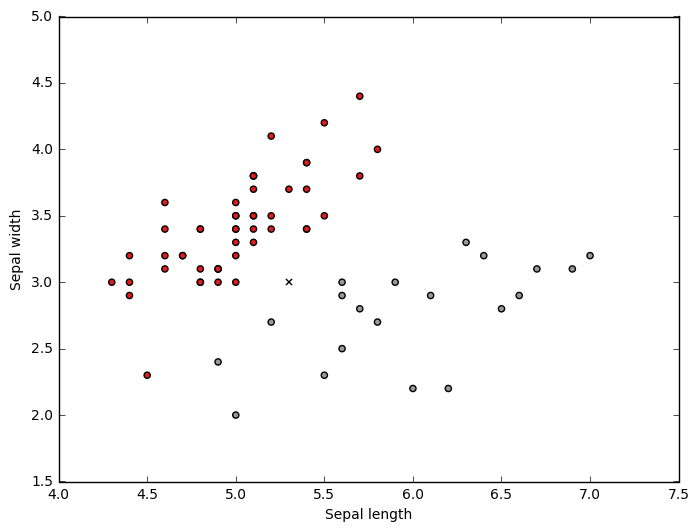

In [4]:
plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X_train[0:70, 0], X_train[0:70, 1], c=y_train[0:70], cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.scatter(x_new[0], x_new[1], c='k', marker='x',cmap=plt.cm.Set1,
            edgecolor='k')

- The weights should be positive for x0, and negative for x1

1) compute weights w^(i) for x query for each training example (w is column vect) 
- w is a weight for each training example to see how close it is to the test example.  
- The test example was printed first, and then the weights and then the training examples. High weight are close by examples. 
- Maximizing the liklihood now will emphasize close by training examples to find theta. 

In [5]:
def w_(X_train,x_new,tau=1.0):
    w = np.zeros((X_train.shape[0]))
    for i in range(X_train.shape[0]):
        xi = X_train[i,:]
        w[i] = np.exp(-1.0*(np.sum((xi-x_new)**2)/(2.0*tau)))
    return(w)

w = w_(X_train,x_new)
print(x_new)
print(w[0:5])
print(X_train[0:5,:])

[ 5.3  3. ]
[ 0.86502229  0.92311635  0.81873075  0.77880078  0.79851622]
[[ 5.1  3.5]
 [ 4.9  3. ]
 [ 4.7  3.2]
 [ 4.6  3.1]
 [ 5.   3.6]]


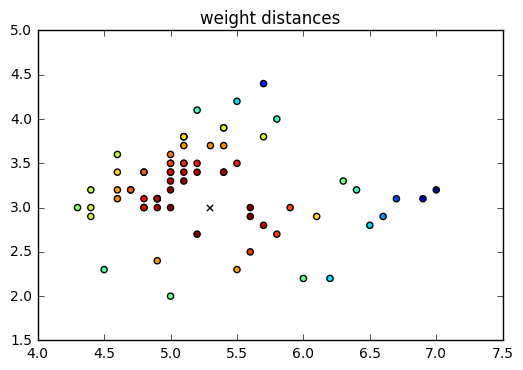

In [6]:
plt.scatter(X_train[0:70, 0], X_train[0:70, 1], c=w[0:70],
            edgecolor='k')
plt.title('weight distances')
plt.scatter(x_new[0], x_new[1], c='k', marker='x',cmap=plt.cm.Set1,
            edgecolor='k')

2) maximize loglik with Newton-Raphson Method

$ \theta := \theta - H(l(\theta))^{-1} \nabla l(\theta) $

The gradient (1xp vector) is: 

$ \nabla l(\theta)=X^Tz-\lambda \theta $

Where:  

$ z_i = w^{(i)}(y^{(i)} - h_{\theta} (x^{(i)}) $

and the Hessian (pxp matrix) is: 

$ H = X^TDX - \lambda I $



Where D is: 

$ D_{ii} = -w^{(i)}h_{\theta} (x^{(i)})(1-h_{\theta} (x^{(i)})) $

In [7]:
def lwlr(X_train,y_train,x_new,tau=1.0,lambbda = 0.0001):


    # initialize theta 
    theta = np.zeros((X_train.shape[1],1))
    
    # calculate w 
    w = np.ones(X_train.shape[0])
    w = w_(X_train,x_new,tau=tau)
    
    # maximize 
    for step in range(50):
        
        #print(theta)
        theta_prev = theta.copy()

        # gradient 
        h = np.squeeze(1.0 / (1.0 + np.exp(-1.0*(np.dot(X_train,theta)))))
        z = w*(y_train-h)
        g = np.dot(X_train.T,z[:,np.newaxis])-theta*lambbda

        # Hessian 
        D = np.eye(X_train.shape[0])*w*h*(1.0-h)
        H = np.dot(-1.0*X_train.T,np.dot(D,X_train)) - lambbda*np.eye(X_train.shape[1])

        
        
        #Newton's Method (still a negative, which he mentioned)
        theta = theta - np.dot(np.linalg.inv(H),g)

        # Gradient ascescent, but this would be positive. 
        #theta = theta + 0.1*g

        
        # loglik # 
        l = w*(y_train*np.log(h+0.0001) + (1-y_train)*(np.log(1-h+0.0001)))
        ll = np.sum(l)-lambbda/2.0*np.dot(theta.T,theta)
        #print(np.linalg.norm(theta))
        #print(step)
        #print(ll)
        #print('ep: {0}').format(diff)
        #print()
    pred_y = np.squeeze(1.0 / (1.0 + np.exp(-1.0*(np.dot(x_new,theta)))))
    return(pred_y)

In [8]:
x_new = np.array([5.3,2.0])
lwlr(X_train,y_train,x_new,0.5)

array(0.9999832045105157)

In [9]:
x_new = np.array([4.0,5.0])
lwlr(X_train,y_train,x_new,0.5)

array(6.330048548748878e-14)

In [10]:
x_new = np.array([6.0,5.0])
lwlr(X_train,y_train,x_new,0.5)

array(5.55229866066817e-12)

In [11]:
def make_meshgrid(x, y, h=.25):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    #Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    return out

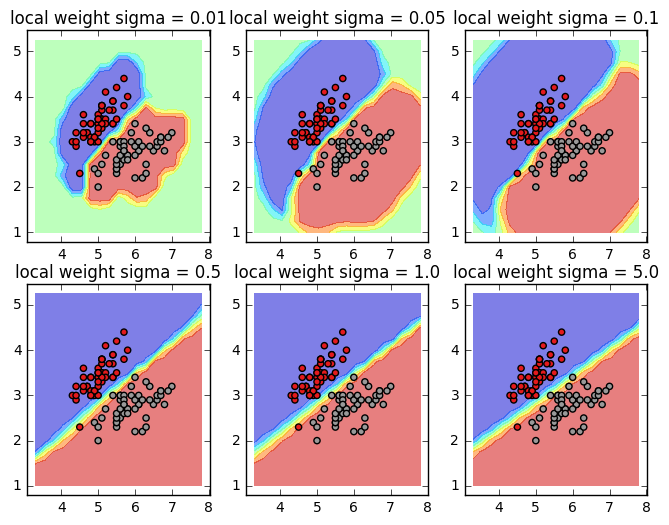

In [12]:
fig,axes = plt.subplots(2,3, figsize=(8, 6))
axes = axes.flatten()


for t,tau in enumerate([0.01,0.05,0.1,0.5,1.0,5.0]):

    # Separation Line
    X0, X1 = X_train[:, 0], X_train[:, 1]
    x0, x1 = make_meshgrid(X0, X1)
    grid_examples = np.c_[x0.ravel(), x1.ravel()]
    Z = np.empty(len(grid_examples))
    for i in range(len(grid_examples)):
        Z[i]= lwlr(X_train,y_train,grid_examples[i,:],tau=tau)
    Z = Z.reshape(x0.shape)
    axes[t].contourf(x0, x1, Z,alpha=0.5)

    # Plot the training points
    axes[t].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Set1,
                edgecolor='k')
    axes[t].set_title('local weight sigma = '+str(tau))
plt.show()

In [13]:
tau


5.0

## Problem 3: 


